# Spatial variations in Chicago's PurpleAir sensor data

There is evidence [1] that there tends to be significant variation in the PM2.5 concentration within urban areas (say, neighborhood to neighborhood) and that health outcomes are correlated with these variations. In this notebook, we consider the concentrations measured by the PurpleAir sensors throughout the Chicago area and study how they vary in space.

[1] Long-Term Exposure to Air Pollution and Incidence of Cardiovascular Events in Women. DOI: https://doi.org/10.1056/nejmoa054409

## Analysis

### Imports and utility

In [45]:
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.precision = 1

Note that in this notebook (unlike some of our other notebooks), both `a` and `b` channels associated to a sensor are assigned the same `sensorID`. In other notebooks the two channels' IDs differ by 1.

The datetime column is a bit hard to work with for data exploration/visualization purposes, so we'll add a column that measures the hours elapsed from the minimum value observed in the whole DataFrame.

In [58]:
df = pd.read_csv('../data/chicago_data.csv', index_col = 0)
df['datetime'] = pd.to_datetime(df['datetime'])
df['hours_elapsed'] = (df['datetime'] - min_time) / timedelta(hours = 1)
df.head()

,sensorID,latitude,longitude,name,channel,datetime,pm25,temp,rh,hours_elapsed
0,3499,41.9,-87.7,Ukrainian Village,a,2022-01-30 00:00:22+00:00,0.0,26.0,42.0,5.8e-03
1,3499,41.9,-87.7,Ukrainian Village,a,2022-01-30 00:02:21+00:00,0.5,26.0,42.0,3.9e-02
2,3499,41.9,-87.7,Ukrainian Village,a,2022-01-30 00:04:22+00:00,0.0,26.0,42.0,7.2e-02
3,3499,41.9,-87.7,Ukrainian Village,a,2022-01-30 00:06:21+00:00,0.6,26.0,42.0,1.1e-01
4,3499,41.9,-87.7,Ukrainian Village,a,2022-01-30 00:08:21+00:00,0.0,26.0,42.0,1.4e-01


### Cleaning data

Let us first check for missing data. We expect there to be a lot of missing data in the `b` channels, as there the temperature and relative humidity columns are not actually what they're labelled (see [here](https://docs.google.com/document/d/15ijz94dXJ-YAZLi9iZ_RaBwrZ4KtYeCy08goGBwnbCU/) for details). We will be keeping the `a` channel's measurements of those two variables.

In [38]:
df_ch_a_missing = df[df['channel'] == 'a'][df[df['channel'] == 'a'].isnull().any(axis = 1)]
df_ch_a_missing['name'].value_counts()

Studio Gang                700
La Paz - Dickens (Roof)    700
Name: name, dtype: int64

### Exploratory visualization

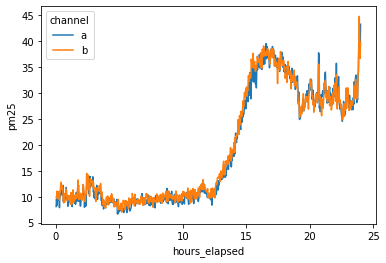

In [68]:
sensor_ids = df['sensorID'].unique()

ax = sns.lineplot(data = df[df['sensorID'] == sensor_ids[9]], x = 'hours_elapsed', y = 'pm25', hue = 'channel');